# How to use PSSGP
This notebook is a primer on how to use PSSGP for your own purposes. For simplicity, we reproduce here
the example listed in https://gpflow.readthedocs.io/en/master/notebooks/basics/regression.html.

In [20]:
import numpy as np
import matplotlib.pyplot as plt

import gpflow
from gpflow.utilities import print_summary

from pssgp.kernels.matern import Matern52
from pssgp.model import StateSpaceGP

We get the same data as in the GPFlow example.

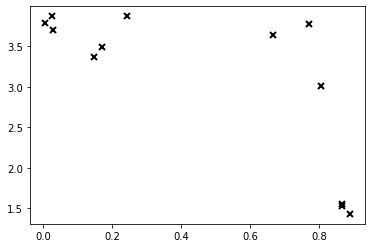

In [21]:
data = np.genfromtxt("data/regression_1D.csv", delimiter=",")  # note that the data is sorted in the X-axis
np.savetxt("data/regression_1D.csv", data, delimiter=",")
X = data[:, 0].reshape(-1, 1)
Y = data[:, 1].reshape(-1, 1)

_ = plt.plot(X, Y, "kx", mew=2)

And we will consider the same model, except that we now import the kernel from pssgp.

In [22]:
k = Matern52()

Note that for the time being we have not implemented non-null mean functions.
This could however be the subject of future improvements, let us know if you would be interested.

We can now define our GP, SSGP and PSSGP models.

In [23]:
gp = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
ssgp = StateSpaceGP(data=(X, Y), kernel=k, parallel=False)
pssgp = StateSpaceGP(data=(X, Y), kernel=k, parallel=True)

We can now use the same optimizers as GPFlow to train our models.


In [24]:
opt = gpflow.optimizers.Scipy()

In [25]:
gp_opt_logs = opt.minimize(gp.training_loss, gp.trainable_variables, options=dict(maxiter=100))
ssgp_opt_logs = opt.minimize(ssgp.training_loss, ssgp.trainable_variables, options=dict(maxiter=100))
pssgp_opt_logs = opt.minimize(pssgp.training_loss, pssgp.trainable_variables, options=dict(maxiter=100))

And we can now compare

In [26]:
print("GP learned parameters")
print_summary(gp)

print("SSGP learned parameters")
print_summary(ssgp)

print("PSSGP learned parameters")
print_summary(pssgp)

GP learned parameters
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 7.96569    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.212416   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.00575949 │
╘═════════════════════════╧═══════════╧═══════════

Prediction is done in the same way too


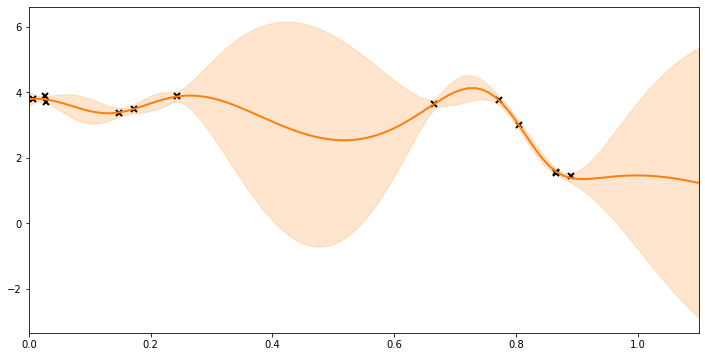

In [27]:
## generate test points for prediction
xx = np.linspace(0., 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
gp_mean, gp_var = gp.predict_f(xx)
pssgp_mean, pssgp_var = pssgp.predict_f(xx)

## plot
plt.figure(figsize=(12, 6))
plt.plot(X, Y, "kx", mew=2)

plt.plot(xx, pssgp_mean, "C1", lw=2)
plt.fill_between(
    xx[:, 0],
    pssgp_mean[:, 0] - 1.96 * np.sqrt(pssgp_var[:, 0]),
    pssgp_mean[:, 0] + 1.96 * np.sqrt(pssgp_var[:, 0]),
    color="C1",
    alpha=0.2,
)

_ = plt.xlim(0., 1.1)


To be compared to the GP plot

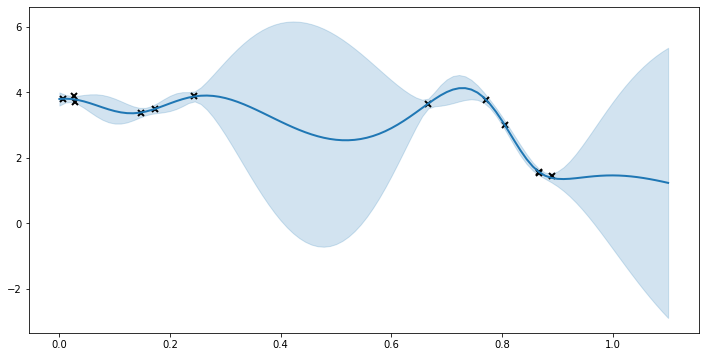

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(X, Y, "kx", mew=2)
plt.plot(xx, gp_mean, "C0", lw=2)
plt.fill_between(
    xx[:, 0],
    gp_mean[:, 0] - 1.96 * np.sqrt(gp_var[:, 0]),
    gp_mean[:, 0] + 1.96 * np.sqrt(gp_var[:, 0]),
    color="C0",
    alpha=0.2,
)